# Flowers Classification using Inception V3 Model

### Download Flowers dataset

In [0]:
#You can download the data manually as well instead of using 'wget'
!wget http://download.tensorflow.org/example_images/flower_photos.tgz --quiet

In [0]:
#Read the dataset
import tarfile
dataset = tarfile.open('flower_photos.tgz')

In [0]:
#We will build a pandas dataset
import pandas as pd
df = pd.DataFrame(columns=['class','image_file'])

In [0]:
#Run through tarfile members 
for name in dataset.getnames(): 
    tar_mem = dataset.getmember(name)    
    #Check if it is a file
    if(tar_mem.isfile() and name.endswith('.jpg')):
        #Build directory and class info

        im_dir = name[0:name.rfind('/')]
        im_class = im_dir[im_dir.rfind('/')+1:]
        
        #Add record to the dataframe
        df.loc[df.shape[0]] = [im_class, name]

In [0]:
#extract data
dataset.extractall(path='')

In [23]:
!ls -l flower_photos

total 828
drwx------ 2 270850 5000  36864 Feb 10  2016 daisy
drwx------ 2 270850 5000  53248 Feb 10  2016 dandelion
-rw-r----- 1 270850 5000 418049 Feb  9  2016 LICENSE.txt
drwx------ 2 270850 5000  36864 Feb 10  2016 roses
drwx------ 2 270850 5000  36864 Feb 10  2016 sunflowers
-rw-r--r-- 1 root   root  42269 Apr 27 11:02 test.csv
-rw-r--r-- 1 root   root 169533 Apr 27 11:02 train.csv
drwx------ 2 270850 5000  45056 Feb 10  2016 tulips


Create Training & Test Dataset

In [0]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [0]:
train_df.to_csv('flower_photos/train.csv',index=False)
test_df.to_csv('flower_photos/test.csv', index=False)

### Read training and test data

In [0]:
#Read training and test Dataframe
train_df = pd.read_csv('flower_photos/train.csv')
test_df = pd.read_csv('flower_photos/test.csv')

In [27]:
#Check contents
train_df.sample(n=5)

,class,image_file
731,daisy,flower_photos/daisy/147068564_32bb4350cc.jpg
2448,sunflowers,flower_photos/sunflowers/9535500195_543d0b729b...
778,tulips,flower_photos/tulips/16711791713_e54bc9c1af_n.jpg
1126,sunflowers,flower_photos/sunflowers/9610098411_f1613c8e14...
1625,dandelion,flower_photos/dandelion/13331969914_890082d898...


In [35]:
#Get class names
class_names = train_df['class'].unique().tolist()
print('Flower classes: ', class_names)

Flower classes:  ['tulips', 'daisy', 'sunflowers', 'dandelion', 'roses']


### Build Batch generator (using ImageDataGenerator)

In [0]:
import tensorflow as tf
import numpy as np

In [0]:
#Define img_size and img-depth parameters
img_size = 224
img_depth = 3  

Function to normalize image according to Model being used

In [0]:
def normalize_data(img):
    #Normalize for MobuleNet and Inception V3
    return tf.keras.applications.inception_v3.preprocess_input(img)

Define ImageDataGenerator for both Training and Test Separately

In [0]:
#Define Training Data Generator with augmentations
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=20,
                                                                width_shift_range=0.2,
                                                                height_shift_range=0.2,
                                                                horizontal_flip=True,
                                                                preprocessing_function=normalize_data) #Normalize the data accordingly

#Define Test Data Generator with NO augmentations
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=normalize_data) #Normalize the data accordingly

Create Data Generators objects for Training and Test

In [41]:
#Training (from dataframe)
train_generator = train_datagen.flow_from_dataframe(train_df, 
                                                    x_col='image_file', #File path for image
                                                    y_col='class',           #Class for the image
                                                    target_size=(img_size, img_size), #Image resize dimensions
                                                    batch_size=64)

Found 2936 validated image filenames belonging to 5 classes.


In [42]:
#Test (from dataframe)
test_generator = test_datagen.flow_from_dataframe(test_df,
                                                  x_col='image_file', #File path for image
                                                  y_col='class',           #Class for the image
                                                  target_size=(img_size, img_size), #Image resize dimensions
                                                  batch_size=64)

Found 734 validated image filenames belonging to 5 classes.


In [44]:
print(train_generator.n, test_generator.n)

2936 734


In [0]:
#Function to compare the metrics - loss and accuracy for training validation stes over a no of epochs
import matplotlib.pyplot as plt
%matplotlib inline
def plot_metrics(history, ax, fontsize, col1, col2, x_label, y_label, title):
    ax.plot((history.history[col1]))
    ax.plot((history.history[col2]))
    #ax.locator_params(nbins=3)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.legend(['Training-data', 'Test-data'])
    ax.set_title(title)

ImageDataGenerator has lot of useful features. Learn more about ImageDataGenerator at https://keras.io/preprocessing/image/

### Load pre-trained Inception V3 model : 

In [0]:
tf.keras.backend.clear_session()
model = tf.keras.applications.inception_v3.InceptionV3(include_top=False, #Do not include classification layer for imagenet
                                       input_shape=(224,224, img_depth),
                                       weights='imagenet')

In [92]:
model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [93]:
model.output

<tf.Tensor 'mixed10/Identity:0' shape=(None, 5, 5, 2048) dtype=float32>

Freeze the layers in Pre-trained model

In [94]:
len(model.layers)

311

In [0]:
#Set pre-trained model layers to not trainable
for layer in model.layers:
    layer.trainable = False

In [96]:
#Check if layers frozen
model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

### Add FC layer for new classes

In [0]:
#get Output layer of Pre-trained model
x = model.output

#add Batch Normalization
x = tf.keras.layers.BatchNormalization()(x)

#add Dropout
x = tf.keras.layers.Dropout(0.50)(x)

#Global average pool to reduce number of features and Flatten the output
x = tf.keras.layers.GlobalAveragePooling2D()(x)

In [98]:
#Output shape of Global Average Pooling
x.get_shape()

TensorShape([None, 2048])

In [0]:
#add Batch Normalization
x = tf.keras.layers.BatchNormalization()(x)

#add Dropout
x = tf.keras.layers.Dropout(0.50)(x)

In [0]:
#Add output layer
prediction = tf.keras.layers.Dense(len(class_names),activation='softmax')(x)

### Building final model for Classification

In [0]:
#Using Keras Model class
final_model = tf.keras.models.Model(inputs=model.input, #Pre-trained model input as input layer
                                    outputs=prediction) #Output layer added

In [0]:
#Compile the model
final_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [103]:
#How does our overall model looks
final_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

### Train the model

In [0]:
#Saving the best model using model checkpoint callback
model_checkpoint=tf.keras.callbacks.ModelCheckpoint('flowers_resnet.h5', 
                                                    save_best_only=True, 
                                                    monitor='val_accuracy', 
                                                    mode='max', 
                                                    verbose=1)

In [105]:
history_finalmodel = final_model.fit_generator(train_generator, 
                          epochs=5,
                          steps_per_epoch= 2936//64,
                          validation_data=test_generator,
                          validation_steps = 734//64, 
                          callbacks=[model_checkpoint])

Epoch 1/5
45/45 [==============================] - 39s 856ms/step - loss: 1.2643 - accuracy: 0.5933 - val_loss: 0.6186 - val_accuracy: 0.7727
Epoch 2/5
45/45 [==============================] - 37s 830ms/step - loss: 0.7396 - accuracy: 0.7570 - val_loss: 0.4936 - val_accuracy: 0.8224
Epoch 3/5
45/45 [==============================] - 38s 835ms/step - loss: 0.6470 - accuracy: 0.7921 - val_loss: 0.4491 - val_accuracy: 0.8366
Epoch 4/5
45/45 [==============================] - 38s 848ms/step - loss: 0.6041 - accuracy: 0.8043 - val_loss: 0.4382 - val_accuracy: 0.8438
Epoch 5/5
45/45 [==============================] - 38s 847ms/step - loss: 0.5279 - accuracy: 0.8210 - val_loss: 0.4276 - val_accuracy: 0.8480


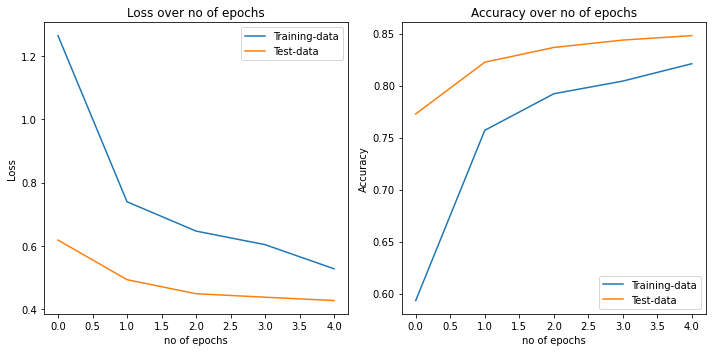

In [108]:
#Plot showing metrics comaparision
plt.close('all')
fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
plot_metrics(history_finalmodel, ax1, 30, 'loss', 'val_loss', 'no of epochs', 'Loss', 'Loss over no of epochs')
plot_metrics(history_finalmodel, ax2, 30, 'accuracy', 'val_accuracy', 'no of epochs', 'Accuracy', 'Accuracy over no of epochs')
plt.tight_layout()
plt.show()

##### When we are freezing all layers in inception v3 pre-trained model, we are seeing a training accuracy of 82% and training accuracy of 85%

In [109]:
#Lets train for 5 more steps
final_model.fit_generator(train_generator, 
                          epochs=10,
                          initial_epoch=5,
                          steps_per_epoch= 2936//64,
                          validation_data=test_generator,
                          validation_steps = 734//64, 
                          callbacks=[model_checkpoint])

Epoch 6/10
45/45 [==============================] - 37s 833ms/step - loss: 0.5479 - accuracy: 0.8141 - val_loss: 0.4029 - val_accuracy: 0.8565
Epoch 7/10
45/45 [==============================] - 38s 839ms/step - loss: 0.4640 - accuracy: 0.8391 - val_loss: 0.4027 - val_accuracy: 0.8594
Epoch 8/10
45/45 [==============================] - 38s 845ms/step - loss: 0.4848 - accuracy: 0.8468 - val_loss: 0.3873 - val_accuracy: 0.8636
Epoch 9/10
45/45 [==============================] - 38s 841ms/step - loss: 0.4615 - accuracy: 0.8370 - val_loss: 0.3723 - val_accuracy: 0.8736
Epoch 10/10
45/45 [==============================] - 38s 833ms/step - loss: 0.4652 - accuracy: 0.8433 - val_loss: 0.3943 - val_accuracy: 0.8565


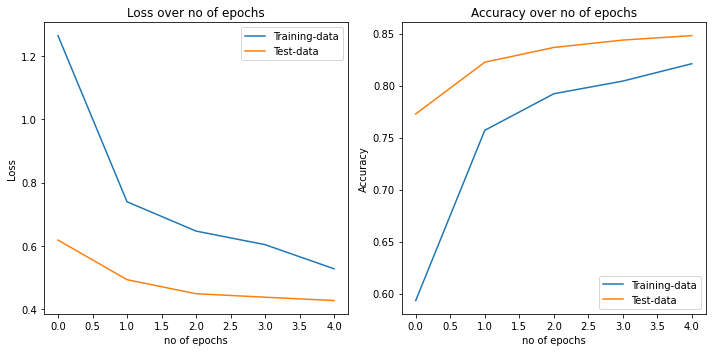

In [110]:
#Plot showing metrics comaparision
plt.close('all')
fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
plot_metrics(history_finalmodel, ax1, 30, 'loss', 'val_loss', 'no of epochs', 'Loss', 'Loss over no of epochs')
plot_metrics(history_finalmodel, ax2, 30, 'accuracy', 'val_accuracy', 'no of epochs', 'Accuracy', 'Accuracy over no of epochs')
plt.tight_layout()
plt.show()

#### After training for 5 more epochs the training accuracy is 84% and validation accuracy of 87%

### Unfreeze some of Trained Layers in ResNet

At this point, our model is overfit. How do we improve our model when using Transfer Learning. Here are some approaches to try:

1. Unfreeze lesser number of layers (fewer parameters to train)
2. Train unfrozen layer with smaller learning rate (avoiding big changes to weights)
3. Use Dropout before output layer

In [113]:
print("Number of Layers in the model:",len(model.layers))
print(len(model.layers) - 0.20*len(model.layers))

Number of Layers in the model: 311
248.8


Let's unfreeze 20% at the end (which have high end features more specific to ImageNet)

In [0]:
#Unfreezing all layers after layer# 249
for layer in model.layers[249:]:
  #print(layer.name)
  layer.trainable = True 

In [115]:
#We will need to recompile the model
final_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
final_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [116]:
#Lets train for 10 steps
final_model.fit_generator(train_generator, 
                          epochs=20,
                          initial_epoch=10,
                          steps_per_epoch= 2936//64,
                          validation_data=test_generator,
                          validation_steps = 734//64, 
                          callbacks=[model_checkpoint])

Epoch 11/20
45/45 [==============================] - ETA: 0s - loss: 0.5929 - accuracy: 0.8297
Epoch 00011: val_accuracy improved from -inf to 0.84801, saving model to flowers_resnet.h5
45/45 [==============================] - 41s 915ms/step - loss: 0.5929 - accuracy: 0.8297 - val_loss: 0.9565 - val_accuracy: 0.8480
Epoch 12/20
45/45 [==============================] - ETA: 0s - loss: 0.2682 - accuracy: 0.9039
Epoch 00012: val_accuracy improved from 0.84801 to 0.85795, saving model to flowers_resnet.h5
45/45 [==============================] - 39s 871ms/step - loss: 0.2682 - accuracy: 0.9039 - val_loss: 0.6922 - val_accuracy: 0.8580
Epoch 13/20
45/45 [==============================] - ETA: 0s - loss: 0.1949 - accuracy: 0.9338
Epoch 00013: val_accuracy improved from 0.85795 to 0.88352, saving model to flowers_resnet.h5
45/45 [==============================] - 39s 872ms/step - loss: 0.1949 - accuracy: 0.9338 - val_loss: 0.4335 - val_accuracy: 0.8835
Epoch 14/20
45/45 [=====================

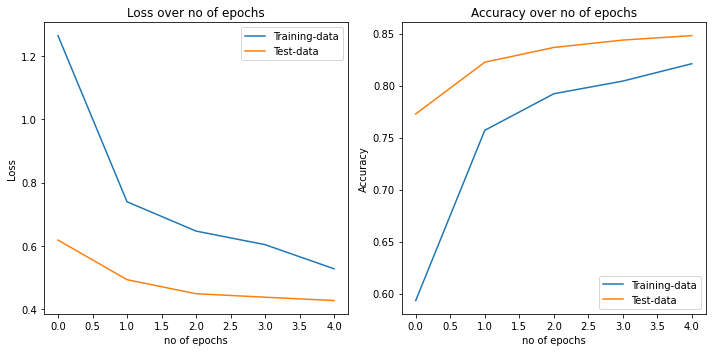

In [117]:
#Plot showing metrics comaparision
plt.close('all')
fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
plot_metrics(history_finalmodel, ax1, 30, 'loss', 'val_loss', 'no of epochs', 'Loss', 'Loss over no of epochs')
plot_metrics(history_finalmodel, ax2, 30, 'accuracy', 'val_accuracy', 'no of epochs', 'Accuracy', 'Accuracy over no of epochs')
plt.tight_layout()
plt.show()

#### After unfreezing last 10% of layers training accuracy is 98% and validation accuracy is 91.3%

In [118]:
#Lets train for 10 more steps
final_model.fit_generator(train_generator, 
                          epochs=30,
                          initial_epoch=20,
                          steps_per_epoch= 2936//64,
                          validation_data=test_generator,
                          validation_steps = 734//64, 
                          callbacks=[model_checkpoint])

Epoch 21/30
45/45 [==============================] - ETA: 0s - loss: 0.0589 - accuracy: 0.9795
Epoch 00021: val_accuracy improved from 0.91335 to 0.91477, saving model to flowers_resnet.h5
45/45 [==============================] - 42s 925ms/step - loss: 0.0589 - accuracy: 0.9795 - val_loss: 0.4734 - val_accuracy: 0.9148
Epoch 22/30
45/45 [==============================] - ETA: 0s - loss: 0.0639 - accuracy: 0.9805
Epoch 00022: val_accuracy did not improve from 0.91477
45/45 [==============================] - 40s 892ms/step - loss: 0.0639 - accuracy: 0.9805 - val_loss: 0.4803 - val_accuracy: 0.9048
Epoch 23/30
45/45 [==============================] - ETA: 0s - loss: 0.0451 - accuracy: 0.9854
Epoch 00023: val_accuracy did not improve from 0.91477
45/45 [==============================] - 40s 897ms/step - loss: 0.0451 - accuracy: 0.9854 - val_loss: 0.5147 - val_accuracy: 0.8935
Epoch 24/30
45/45 [==============================] - ETA: 0s - loss: 0.0380 - accuracy: 0.9868
Epoch 00024: val_acc

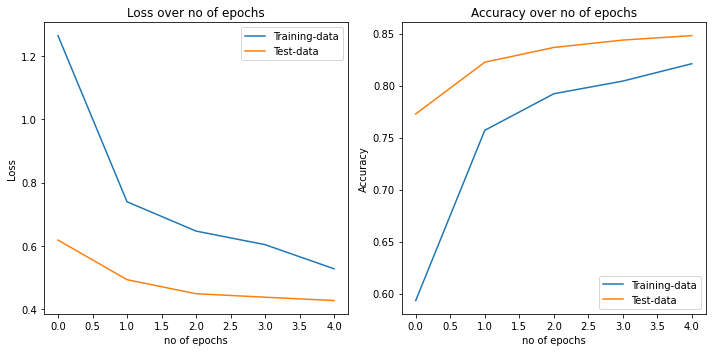

In [119]:
#Plot showing metrics comaparision
plt.close('all')
fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
plot_metrics(history_finalmodel, ax1, 30, 'loss', 'val_loss', 'no of epochs', 'Loss', 'Loss over no of epochs')
plot_metrics(history_finalmodel, ax2, 30, 'accuracy', 'val_accuracy', 'no of epochs', 'Accuracy', 'Accuracy over no of epochs')
plt.tight_layout()
plt.show()

#### Training Accuracy is 98.7% and Validation Accuracy is 91.4%